In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from warnings import filterwarnings
import numpy as np
from etna.datasets import TSDataset
from etna.analysis import plot_correlation_matrix
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from etna.analysis import get_anomalies_density
from etna.analysis import get_anomalies_median
from etna.analysis import plot_anomalies
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform
from etna.analysis import seasonal_plot
from etna.analysis import stl_plot
from datetime import date
import holidays
from datetime import datetime, date
from etna.transforms.missing_values.imputation import TimeSeriesImputerTransform
from sklearn.metrics import mean_absolute_error
from etna.models import NaiveModel
from copy import deepcopy
from custom_transforms import *
from etna.transforms import *
from sklearn.model_selection import TimeSeriesSplit
from etna.models import CatBoostPerSegmentModel
from etna.pipeline import Pipeline, AutoRegressivePipeline
from statsmodels.tsa.arima.model import ARIMA
from etna.auto import Tune
from etna.metrics import SMAPE
from etna.distributions import IntDistribution
from warnings import filterwarnings
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit



In [1]:
filterwarnings('ignore')
train = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')
train.rename(columns={'dt':'timestamp','id':'segment'},inplace=True)

In [2]:

ts_train = TSDataset(train,freq='D')

# EDA

Посмотрим на длину рядов посегментно, а также на наличие пропущенных значений

In [3]:
ts_train.info()

<class 'etna.datasets.TSDataset'>
num_segments: 20
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
0             2016-01-02    2017-05-30     515           88
1             2016-01-02    2017-05-30     515           88
10            2016-01-02    2017-05-30     515          246
11            2016-01-02    2017-05-30     515           89
12            2016-01-02    2017-05-30     515           91
13            2016-01-02    2017-05-30     515          246
14            2016-01-02    2017-05-30     515           90
15            2016-01-02    2017-05-30     515           88
16            2016-01-02    2017-05-30     515           89
17            2016-01-02    2017-05-30     515          246
18            2016-01-02    2017-05-30     515           92
19            2016-01-02    2017-05-30     515           89
2             2016-01-02    2017-05-30     515    

Максимальная длина отсутствующих значений

In [4]:
for i in range(19):
    print(f'Segment {i}',ts_train.df[(f'{i}','target')].isna().astype(int).groupby(ts_train.df[(f'{i}','target')].notna().astype(int).cumsum()).sum().max())

Segment 0 2
Segment 1 2
Segment 2 2
Segment 3 2
Segment 4 185
Segment 5 2
Segment 6 2
Segment 7 2
Segment 8 185
Segment 9 2
Segment 10 185
Segment 11 2
Segment 12 2
Segment 13 185
Segment 14 2
Segment 15 2
Segment 16 2
Segment 17 185
Segment 18 2


Стоит разделить сегменты на отдельные выборки, так как в некоторых сегментах пробел слишком большой

In [5]:
segments_with_space = np.array([10,13,17,4,8])
segments_with_nospace = np.array(list(set(np.arange(0,19)) - set(segments_with_space)))

In [6]:
ts_train_space = TSDataset(train[train.segment.isin(segments_with_space)][train.timestamp>='2017-01-01'],freq='D')
ts_train_nospace = TSDataset(train[~train.segment.isin(segments_with_space)],freq='D')

### Корреляции

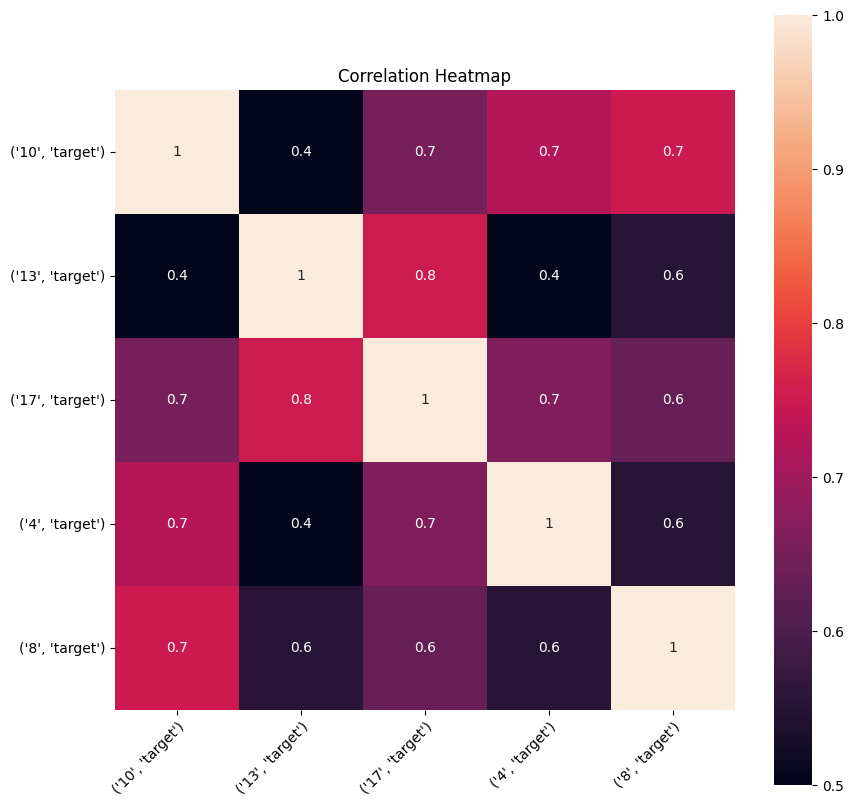

In [7]:
plot_correlation_matrix(ts_train_space, segments=segments_with_space.astype(str), method="spearman", vmin=0.5, vmax=1)

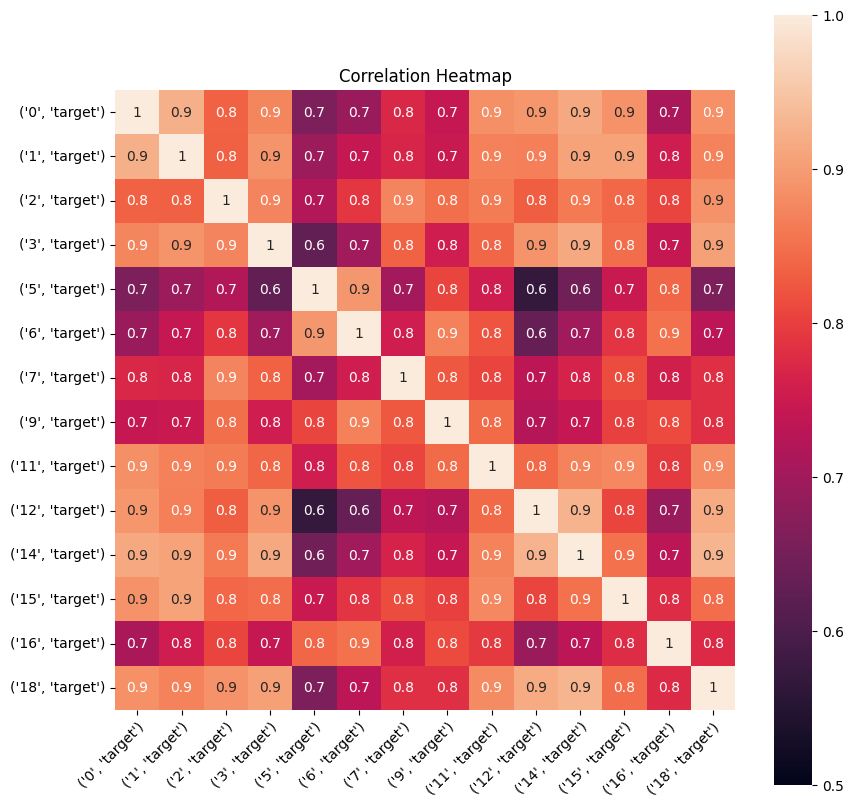

In [8]:
plot_correlation_matrix(ts_train_nospace, segments=segments_with_nospace.astype(str), method="spearman", vmin=0.5, vmax=1)


**Итог:** Имеем сильно скоррелированные ряды в обеих выборках. Наталкивает на мысль, что магазины имеют одинаковую тенденцию по спросу: имеют схожие товары, расположение или продуктивность работы.

Возможно, это поможет в построении итоговых моделей

### ACF

In [9]:
def acf_plotter(ts_dataset,is_space=True):
    if is_space:
        num_segments = 5
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex=True, sharey=True)
        fig.suptitle("ACF для 5 сегментов")
        axes = axes.flatten()
        for j,i in enumerate([10,13,17,4,8]):
            segment_name = f'{i}'
            plot_acf(ts_dataset.df[(segment_name,'target')].dropna(), ax=axes[j], title=f'ACF: {segment_name}')
    else:
        num_segments = 15
        fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10), sharex=True, sharey=True)
        fig.suptitle("ACF для 15 сегментов")
        axes = axes.flatten()
        for j,i in enumerate([0,1,11,12,14,15,16,18,19,2,3,5,6,7,9]):
            segment_name = f'{i}'
            plot_acf(ts_dataset.df[(segment_name,'target')].dropna(), ax=axes[j], title=f'ACF: {segment_name}')
    for j in range(num_segments, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

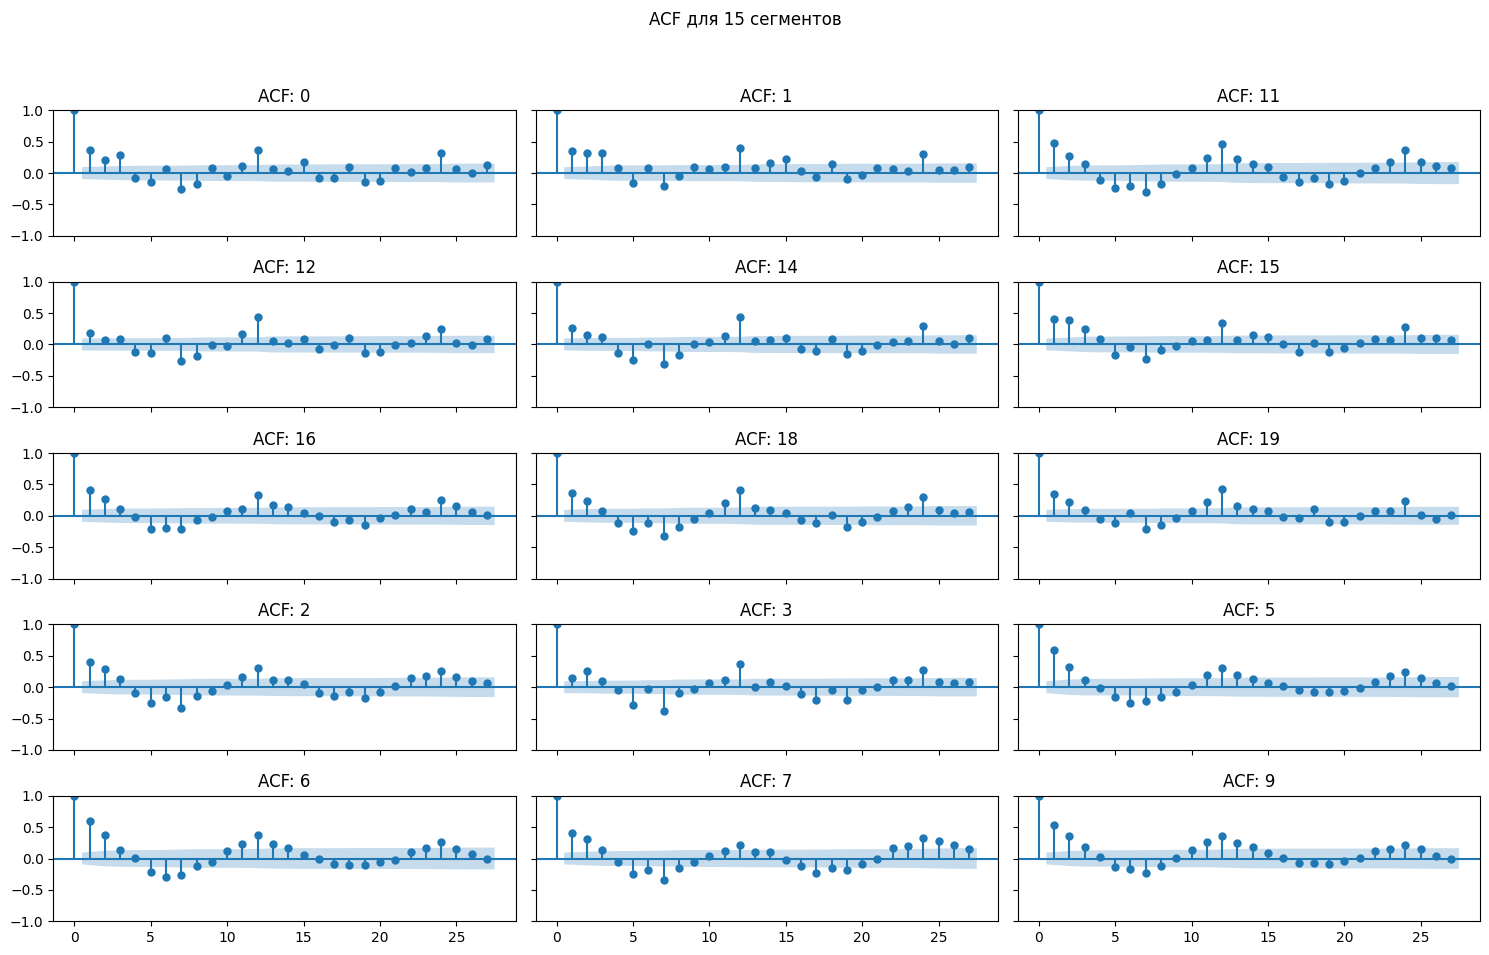

In [10]:
acf_plotter(ts_train_nospace,is_space=False)

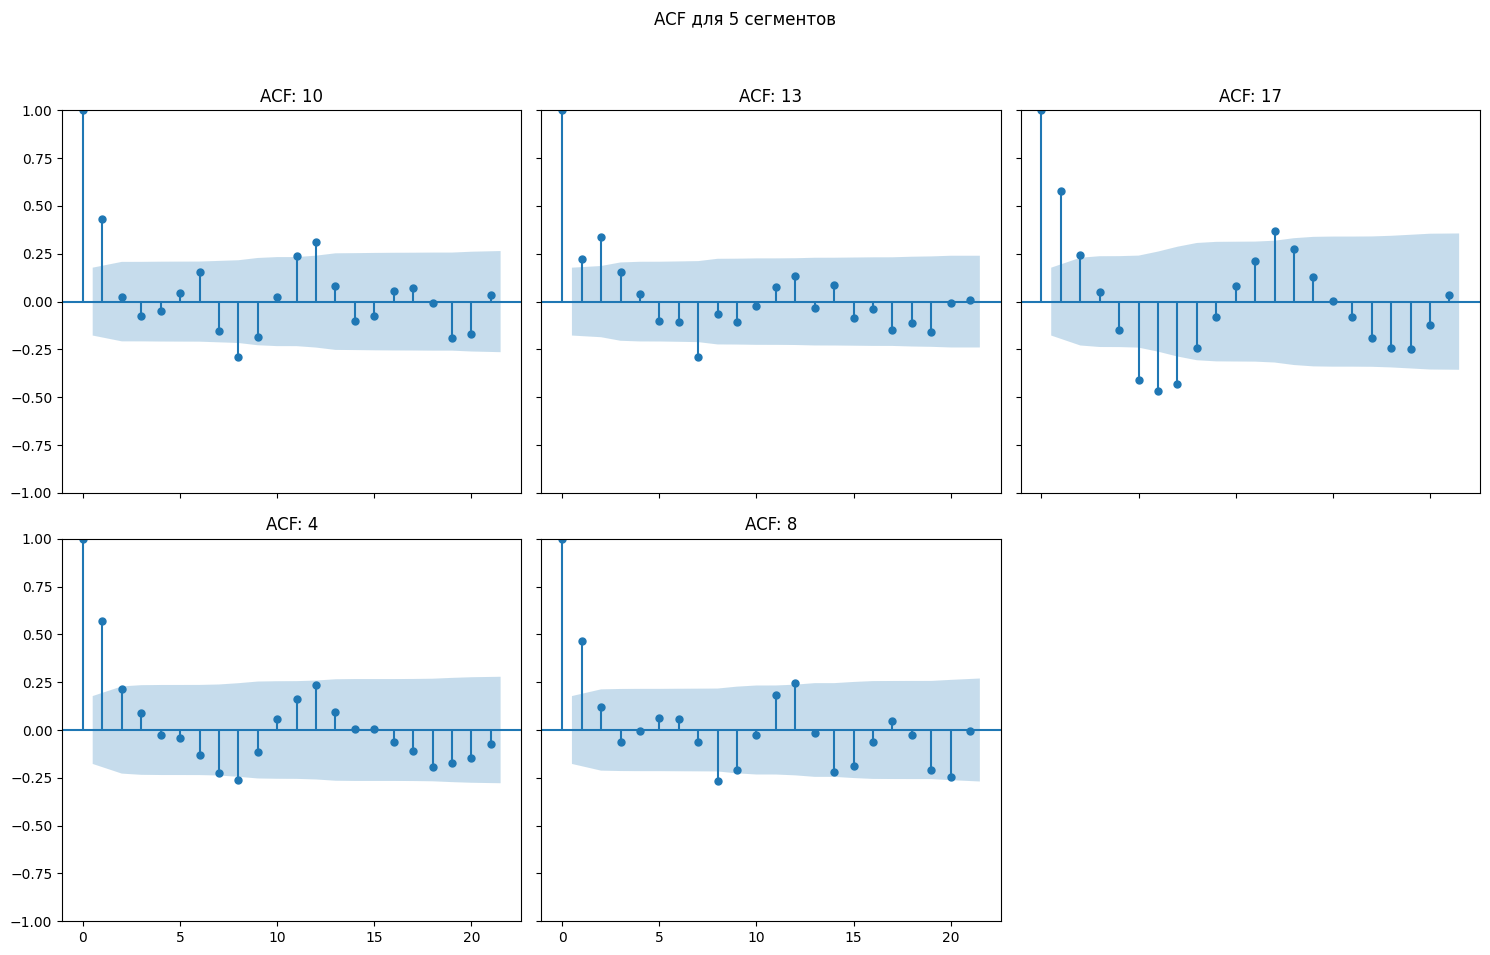

In [11]:
acf_plotter(ts_train_space,is_space=True)

**Итог:** По графикам автокорреляций для каждого сегмента можно заметить, что у большинства сегментов проглядывается синусоидальное поведение. На основе ACF будем выбирать лаги, а также использовать в некоторых моделях при выборе параметров. Помимо этого видно, что присутствуют значимые лаги, то есть наш исходный ряд не похож на случайное блуждание.

### ADF

In [12]:
def adf_test(ts_dataset, is_space=True,alpha=0.05):
    df = {'Сегмент':[], 'Гипотеза':[]}
    if is_space:
        for i in [10,13,17,4,8]:
            result = adfuller(ts_dataset.df[(str(i),'target')].dropna().values)
            p_val = result[1]
            df['Сегмент'].append(i)
            df['Гипотеза'].append('не отвергается'*(p_val < alpha) + 'отвергается'*(p_val>=alpha))
    else:
        for i in [0,1,11,12,14,15,16,18,19,2,3,5,6,7,9]:
            result = adfuller(ts_dataset.df[(str(i),'target')].dropna().values)
            p_val = result[1]
            df['Сегмент'].append(i)
            df['Гипотеза'].append('не отвергается'*(p_val < alpha) + 'отвергается'*(p_val>=alpha))
    return pd.DataFrame(df)
df1 = adf_test(ts_train_space)
df2 = adf_test(ts_train_nospace,is_space=False)
pd.concat([df1,df2],axis=0).sort_values(by='Сегмент')

Сегмент        Гипотеза
0         0  не отвергается
1         1  не отвергается
9         2  не отвергается
10        3  не отвергается
3         4     отвергается
11        5  не отвергается
12        6  не отвергается
13        7  не отвергается
4         8  не отвергается
14        9  не отвергается
0        10     отвергается
2        11  не отвергается
3        12  не отвергается
1        13  не отвергается
4        14  не отвергается
5        15  не отвергается
6        16  не отвергается
2        17  не отвергается
7        18  не отвергается
8        19  не отвергается

**Итог:** ADF-тест позволяет проверить ряд на стационарность. Большинство наших рядов проходят этот тест, а значит имеет смысл использовать ARIMA модели.

### Анализ сезонности

In [14]:
def period_finder(ts_dataset, vals):
    df = {'Segment':[],'Periods':[]}
    for i in vals:
        periods_alpha = list()
        for period in range(7,45):
            res = STL(ts_dataset.df[(f'{i}','target')].dropna(),period=period).fit().resid
            if shapiro(res).pvalue > 0.05:
                periods_alpha.append(period)
        df['Segment'].append(i)
        df['Periods'].append(periods_alpha)
    return pd.DataFrame(df)

In [15]:
df1 = period_finder(ts_train_nospace,[0,1,11,12,14,15,16,18,19,2,3,5,6,7,9])
df2 = period_finder(ts_train_space,[10,13,17,4,8])
pd.concat([df1,df2],axis=0)

Segment                                            Periods
0         0  [13, 14, 22, 23, 25, 26, 29, 30, 35, 36, 37, 3...
1         1                            [7, 14, 22, 23, 25, 29]
2        11                                                 []
3        12               [14, 17, 22, 23, 25, 26, 38, 39, 43]
4        14           [14, 17, 18, 23, 25, 26, 35, 37, 38, 41]
5        15                                                 []
6        16                                                 []
7        18                                           [23, 38]
8        19    [7, 10, 14, 18, 19, 22, 26, 34, 35, 38, 41, 43]
9         2  [11, 13, 18, 22, 23, 24, 25, 26, 35, 36, 37, 3...
10        3       [10, 22, 23, 24, 25, 26, 35, 36, 37, 38, 44]
11        5  [8, 14, 16, 18, 20, 22, 25, 27, 30, 36, 37, 39...
12        6                                    [8, 18, 30, 42]
13        7                                    [7, 13, 23, 37]
14        9                                               [18]
0        10  [8, 11, 12, 14, 16, 17, 18, 19, 22, 23, 26, 27...
1        13  [8, 9, 10, 12, 14, 15, 16, 17, 18, 20, 23, 24,...
2        17               [12, 15, 19, 20, 21, 24, 25, 31, 38]
3         4  [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
4         8  [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...

**Итог:** Для того, чтобы вычислить лучшую периодичность для выявления сезонности будем проводить STL разложение исходного ряда и проверять остатки на нормальность с помощью теста Шапиро-Уилка. В случае выполнения теста будем считать, что вышло разложить ряд. Для 11,15,16 сегментов не удалось выявить стат.значимое значение периодичности.

In [16]:
data = pd.concat([df1,df2],axis=0)

In [17]:
def seasonal_plotter(ts_dataset, is_space, periods):
    if is_space:
        num_segments = 5
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex=True, sharey=True)
        fig.suptitle("Сезонности для 5 сегментов")
        axes = axes.flatten()
        for j,i in enumerate([10,13,17,4,8]):
            segment_name = f'{i}'
            if periods[periods.Segment==i].Periods.values[0] != list():
                period = min(periods[periods.Segment==i].Periods.values[0])
                res = STL(ts_dataset.df[(segment_name,'target')].dropna(),period=period).fit().seasonal
                if period < 31:
                    axes[j].plot(res.resample('W').mean())
                    axes[j].set_title(f'Segment: {i}, Period: {period}')
                else:
                    axes[j].plot(res.resample('M').mean())
                    axes[j].set_title(f'Segment: {i}, Period: {period}')
            else:
                axes[j].set_title(f'Segment: {i}, No Period')
    else:
        num_segments = 15
        fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10), sharex=True, sharey=True)
        fig.suptitle("Сезонности для 15 сегментов")
        axes = axes.flatten()
        for j,i in enumerate([0,1,11,12,14,15,16,18,19,2,3,5,6,7,9]):
            segment_name = f'{i}'
            if periods[periods.Segment==i].Periods.values[0] != list():
                period = min(periods[periods.Segment==i].Periods.values[0])
                res = STL(ts_dataset.df[(segment_name,'target')].dropna(),period=period).fit().seasonal
                if period < 31:
                    axes[j].plot(res.resample('W').mean())
                    axes[j].set_title(f'Segment: {i}, Period: {period}')
                else:
                    axes[j].plot(res.resample('M').mean())
                    axes[j].set_title(f'Segment: {i}, Period: {period}')
            else:
                axes[j].set_title(f'Segment: {i}, No Period')
    for j in range(num_segments, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

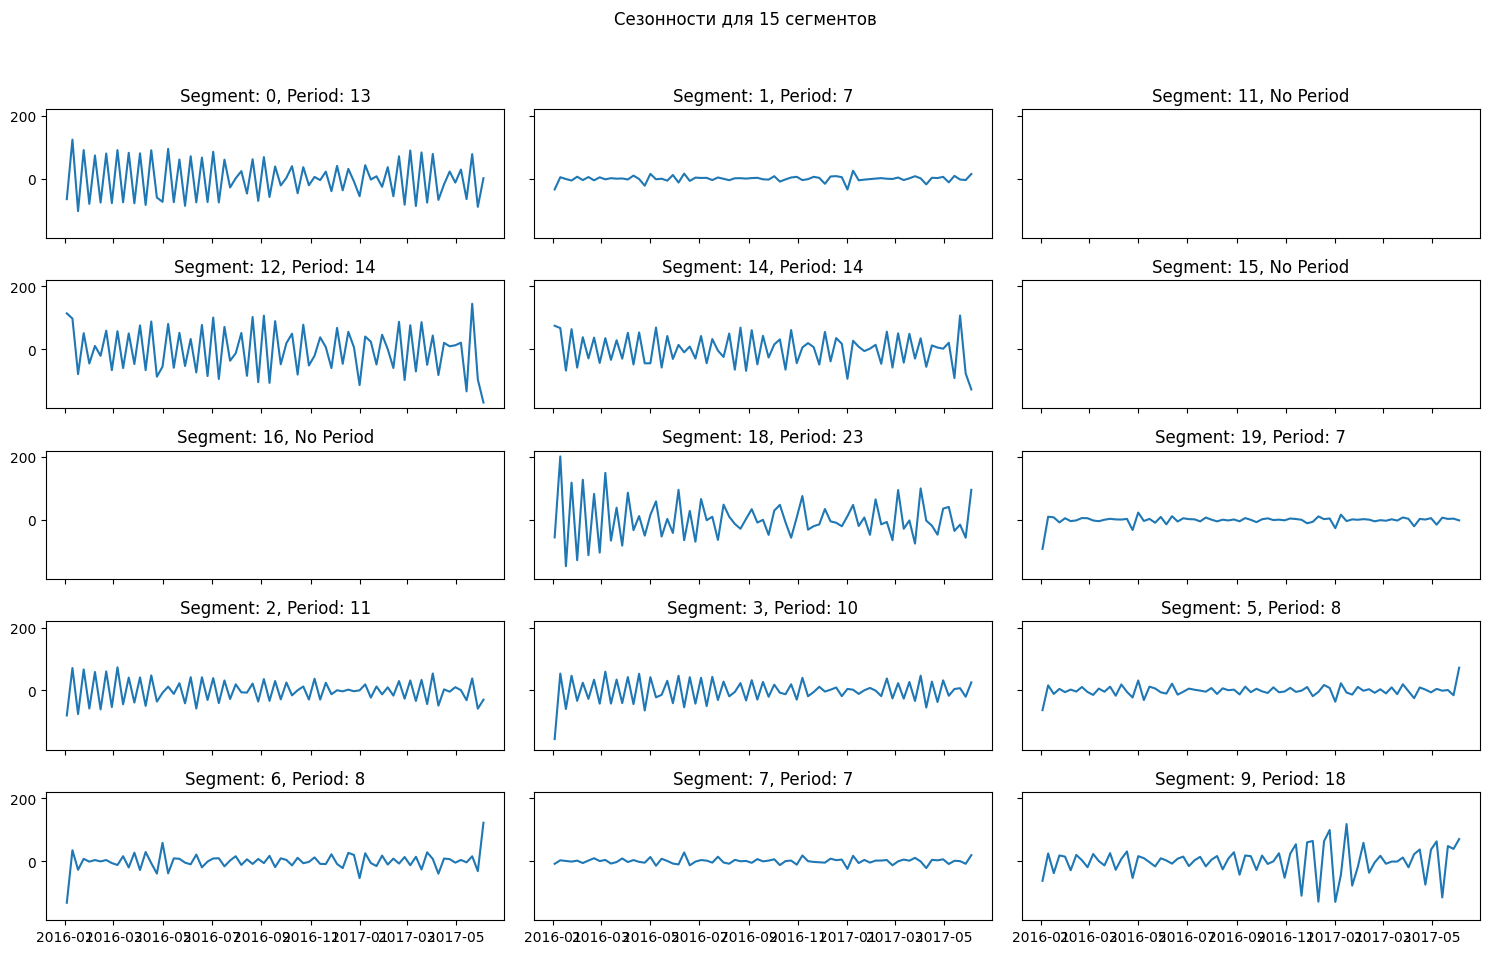

In [18]:
seasonal_plotter(ts_train_nospace,False,data)

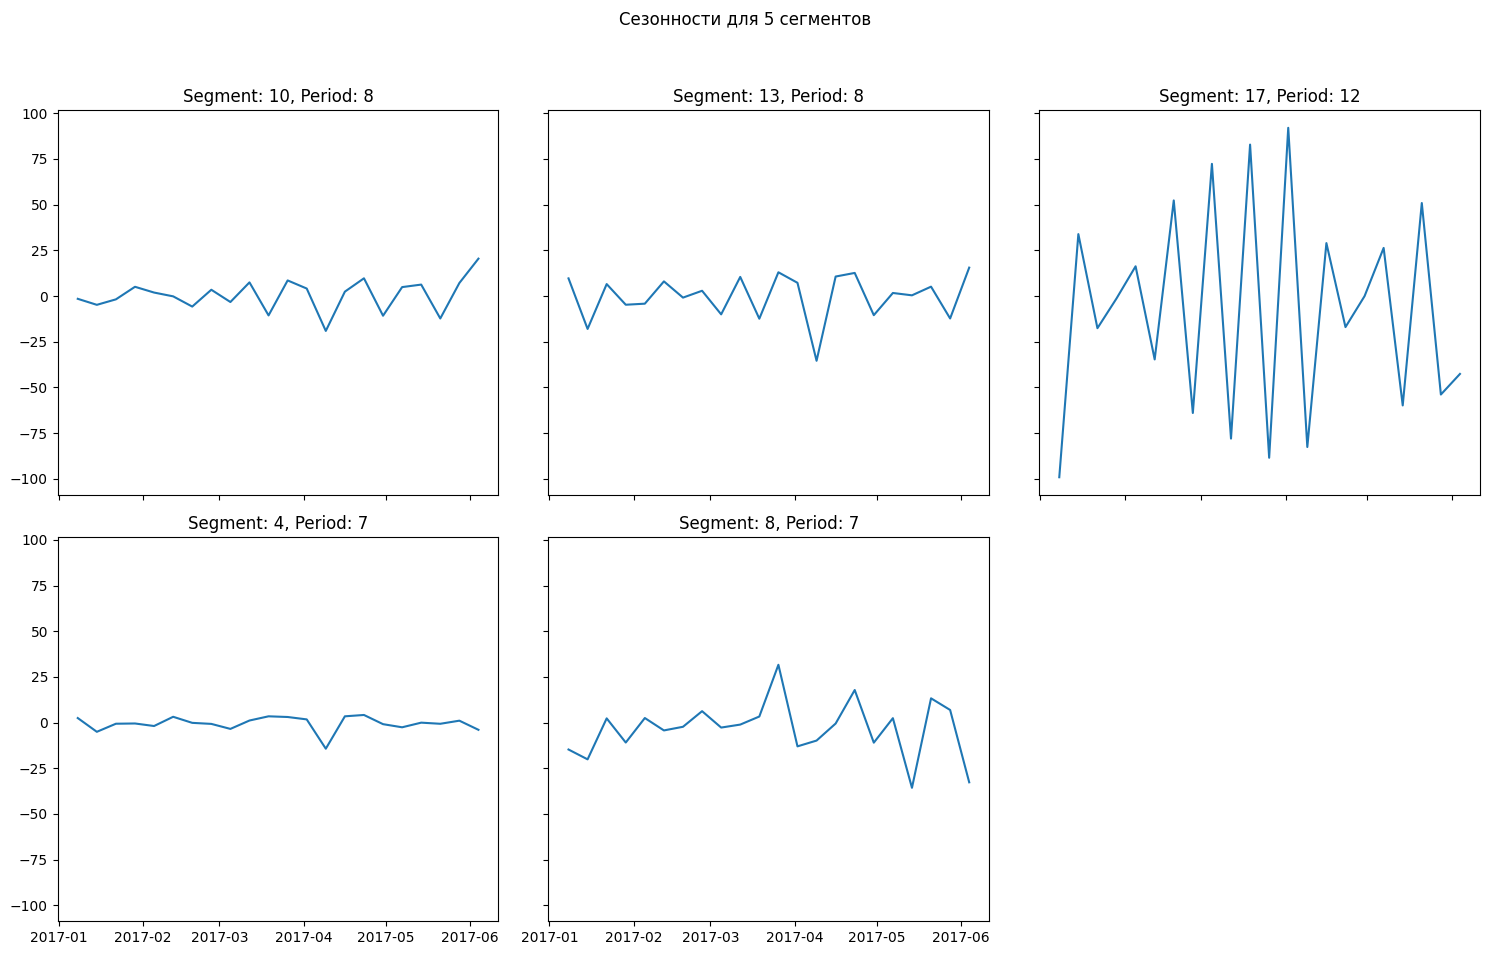

In [19]:
seasonal_plotter(ts_train_space,True,data)

In [21]:
trends = [
    LinearTrendTransform(in_column="target", poly_degree=1),
    LinearTrendTransform(in_column="target", poly_degree=2),
]

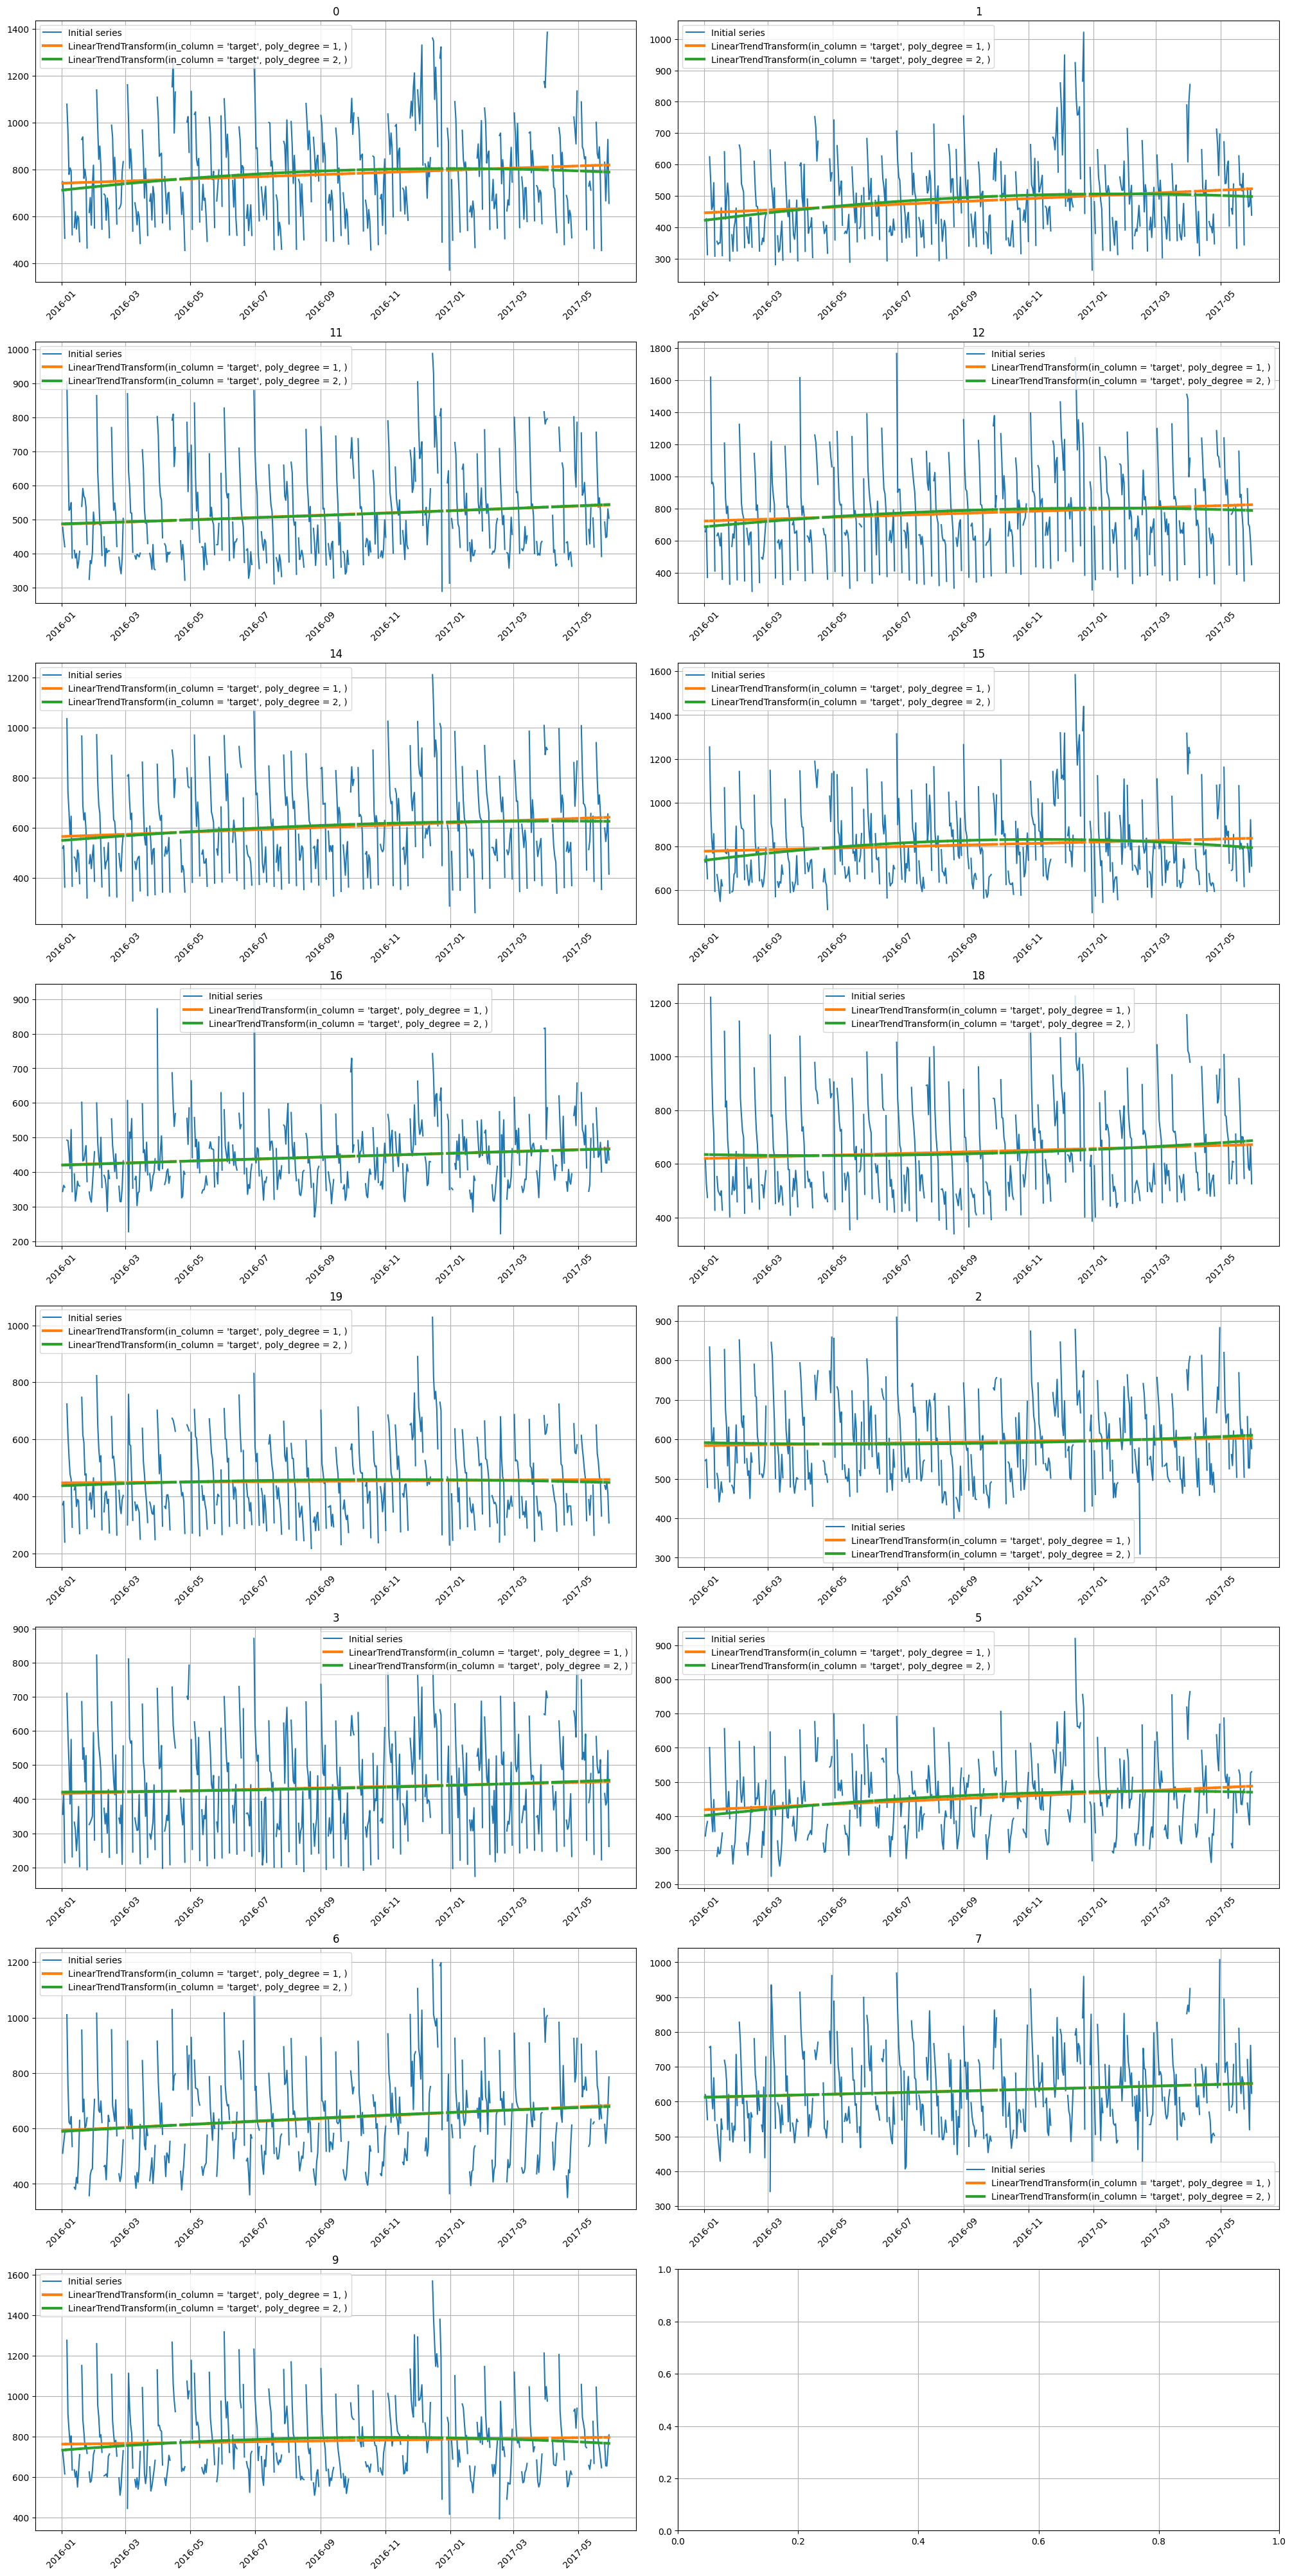

In [22]:
plot_trend(ts_train_nospace, trend_transform=trends)

**Итог:** Видно, что у большинства сегментов тренда как такового не наблюдается.

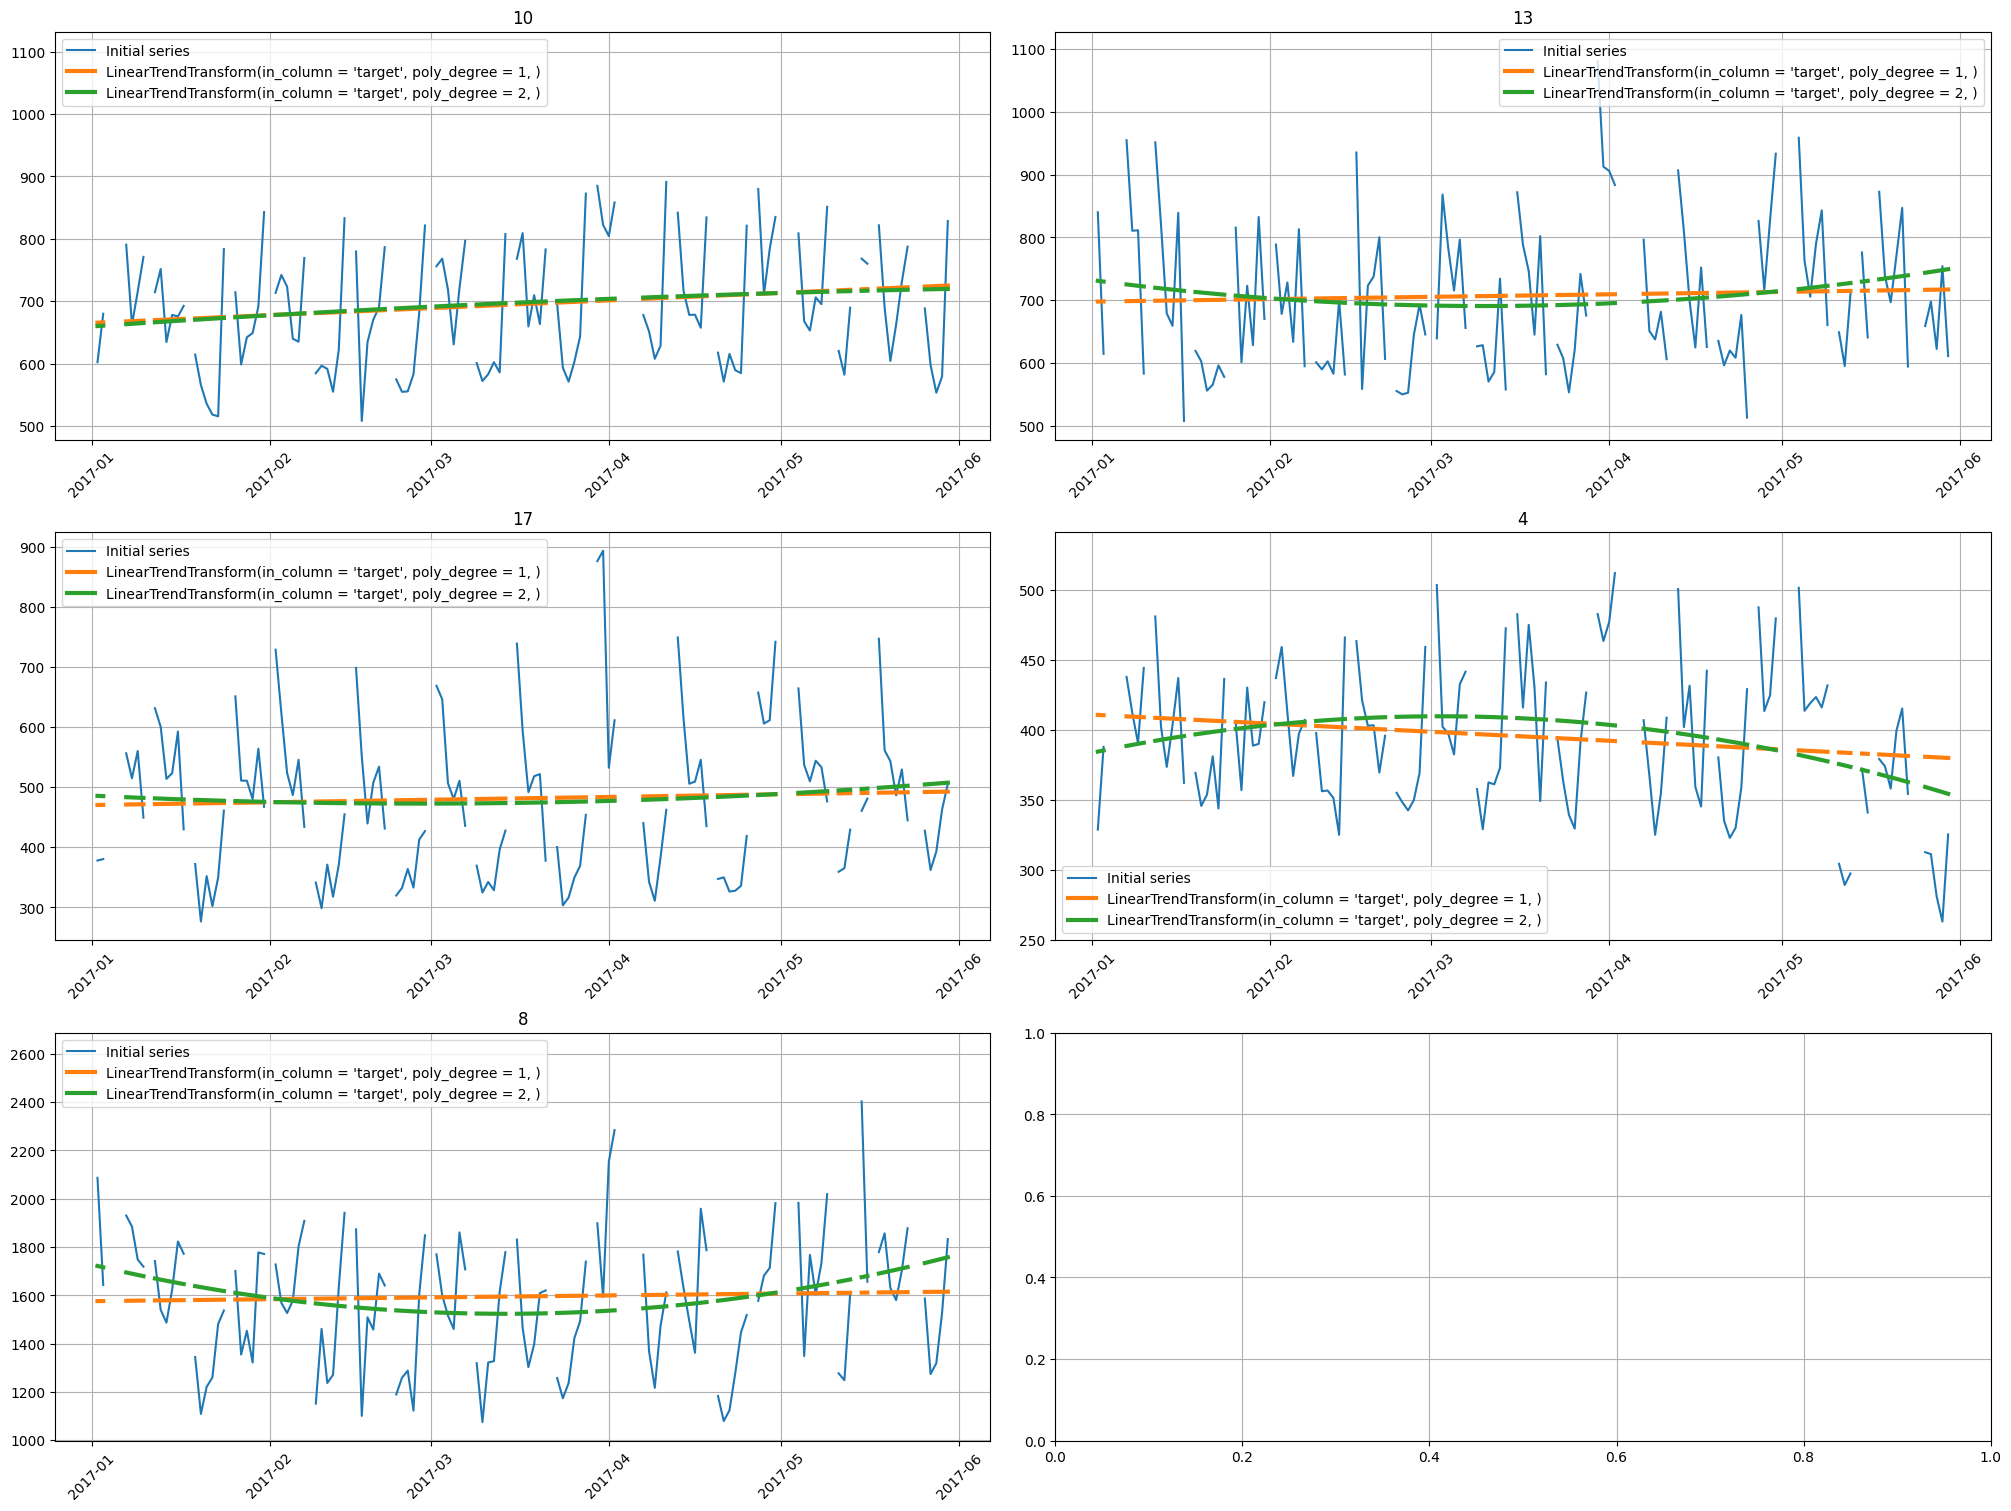

In [23]:
plot_trend(ts_train_space, trend_transform=trends)

**Итог:** Для сегментов 10 и 8 можно заметить слабый восходящий тренд, а для 4 сегмента виден нисходящий тренд. Остальные имеют слабовыраженный тренд

### Пропущенные значения

> train_nospace

In [24]:
us_holidays = holidays.country_holidays('RUS')
a = set()
for j in [0,1,11,12,14,15,16,18,19,2,3,5,6,7,9]:
    for i in pd.Series(ts_train_nospace.df[(f'{j}','target')][ts_train_nospace.df[(f'{j}','target')].isna()].index):
        if us_holidays.get(i) is not None:
            a.add(us_holidays.get(i))
print('Праздники в пропущенных значениях: ', a)

Праздники в пропущенных значениях:  {'Международный женский день', 'Новогодние каникулы', 'Праздник Весны и Труда', 'День защитника Отечества'}


In [25]:
def is_weekend(d = datetime.today()):
  return d.weekday() > 4
for j in [0,1,11,12,14,15,16,18,19,2,3,5,6,7,9]:
  print(f'Количество выходных в пропущенных для сегмента {j}: ',pd.Series(ts_train_nospace.df[(f'{j}','target')][ts_train_nospace.df[(f'{j}','target')].isna()].index).apply(is_weekend).sum())

Количество выходных в пропущенных для сегмента 0:  5
Количество выходных в пропущенных для сегмента 1:  5
Количество выходных в пропущенных для сегмента 11:  6
Количество выходных в пропущенных для сегмента 12:  5
Количество выходных в пропущенных для сегмента 14:  6
Количество выходных в пропущенных для сегмента 15:  5
Количество выходных в пропущенных для сегмента 16:  6
Количество выходных в пропущенных для сегмента 18:  6
Количество выходных в пропущенных для сегмента 19:  6
Количество выходных в пропущенных для сегмента 2:  6
Количество выходных в пропущенных для сегмента 3:  6
Количество выходных в пропущенных для сегмента 5:  6
Количество выходных в пропущенных для сегмента 6:  6
Количество выходных в пропущенных для сегмента 7:  6
Количество выходных в пропущенных для сегмента 9:  6


**Итог:** Можно сделать вывод, что пропущенные значения - рабочие дни. Праздников в эти даты по большей части нет.

> train_space

In [26]:
us_holidays = holidays.country_holidays('RUS')
a = set()
for j in [10,13,17,4,8]:
    for i in pd.Series(ts_train_space.df[(f'{j}','target')][ts_train_space.df[(f'{j}','target')].isna()].index):
        if us_holidays.get(i) is not None:
            a.add(us_holidays.get(i))
print('Праздники в пропущенных значениях: ', a)

Праздники в пропущенных значениях:  {'Новогодние каникулы', 'Праздник Весны и Труда', 'Международный женский день'}


In [27]:
def is_weekend(d = datetime.today()):
  return d.weekday() > 4
for j in [10,13,17,4,8]:
  print(f'Количество выходных в пропущенных для сегмента {j}: ',pd.Series(ts_train_space.df[(f'{j}','target')][ts_train_space.df[(f'{j}','target')].isna()].index).apply(is_weekend).sum())

Количество выходных в пропущенных для сегмента 10:  1
Количество выходных в пропущенных для сегмента 13:  1
Количество выходных в пропущенных для сегмента 17:  1
Количество выходных в пропущенных для сегмента 4:  1
Количество выходных в пропущенных для сегмента 8:  1


**Итог:** Здесь можно сделать аналогичный вывод.

#### Выбросы

**Заполняем пробелы в данных**

In [28]:
ts_train_nospace.fit_transform(
    [
        TimeSeriesImputerTransform(strategy="seasonal", seasonality=30),
        TimeSeriesImputerTransform(strategy="mean", window=7),
    ]
)
ts_train_space.fit_transform(
    [
        TimeSeriesImputerTransform(strategy="seasonal", seasonality=30),
        TimeSeriesImputerTransform(strategy="mean", window=7),
    ]
)

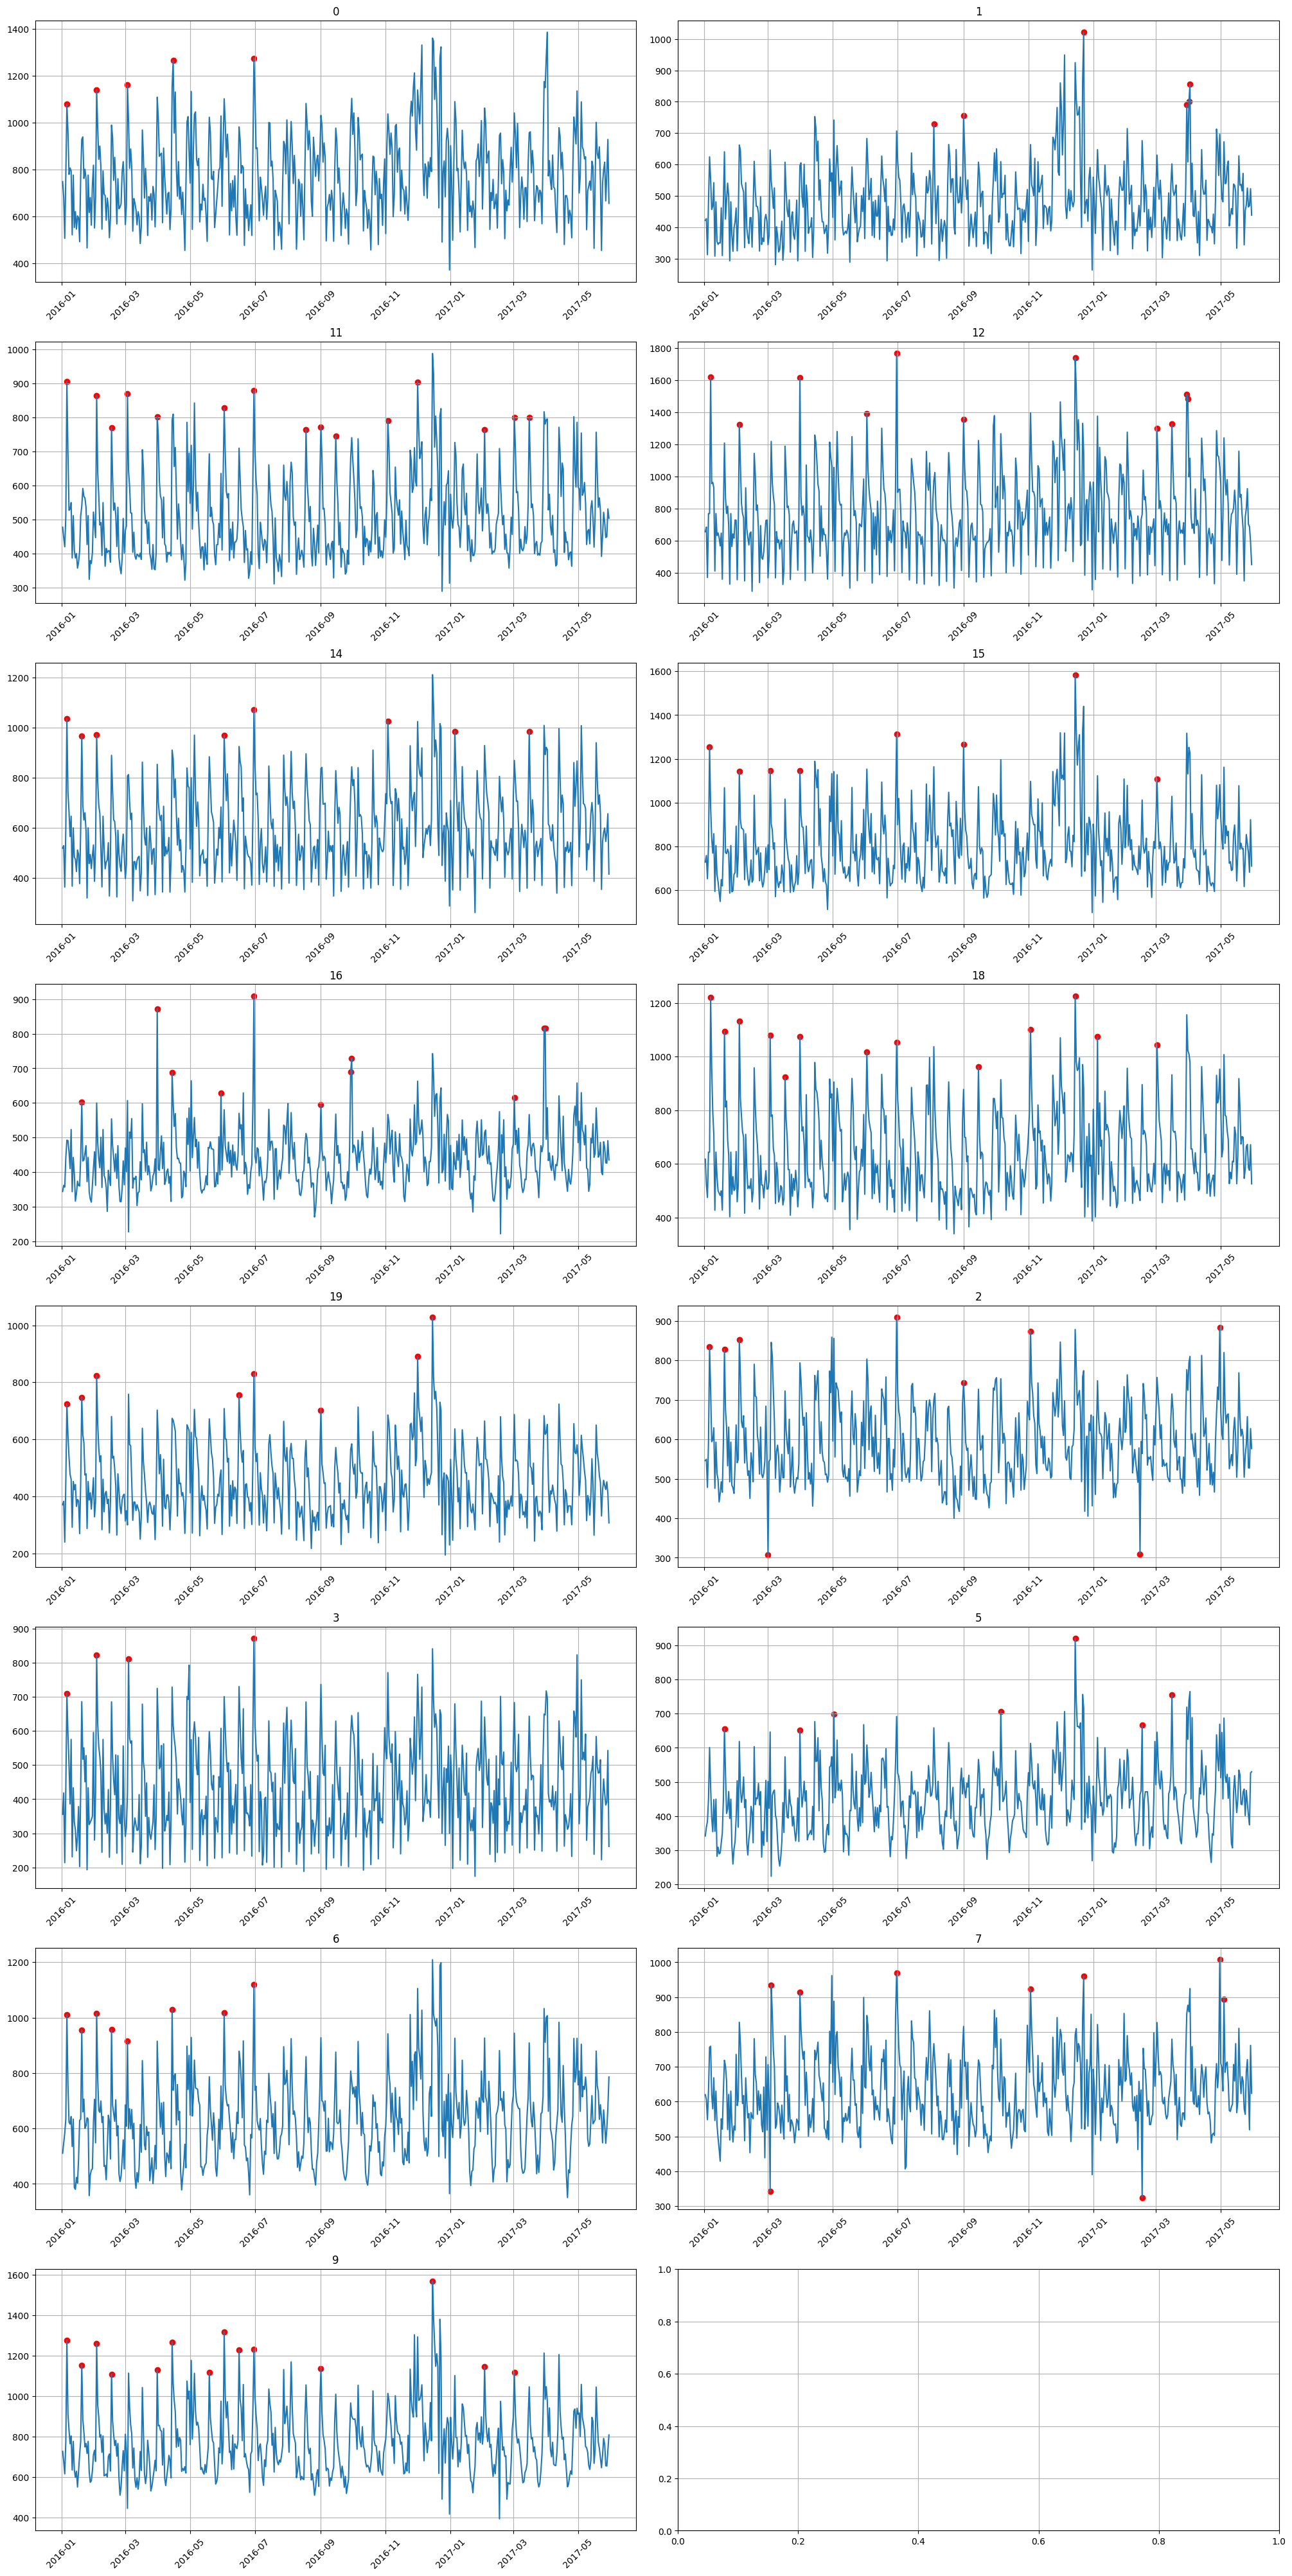

In [29]:
anomaly_dict = get_anomalies_density(ts_train_nospace, window_size=14, distance_coef=1.5, n_neighbors=3)
plot_anomalies(ts_train_nospace, anomaly_dict)

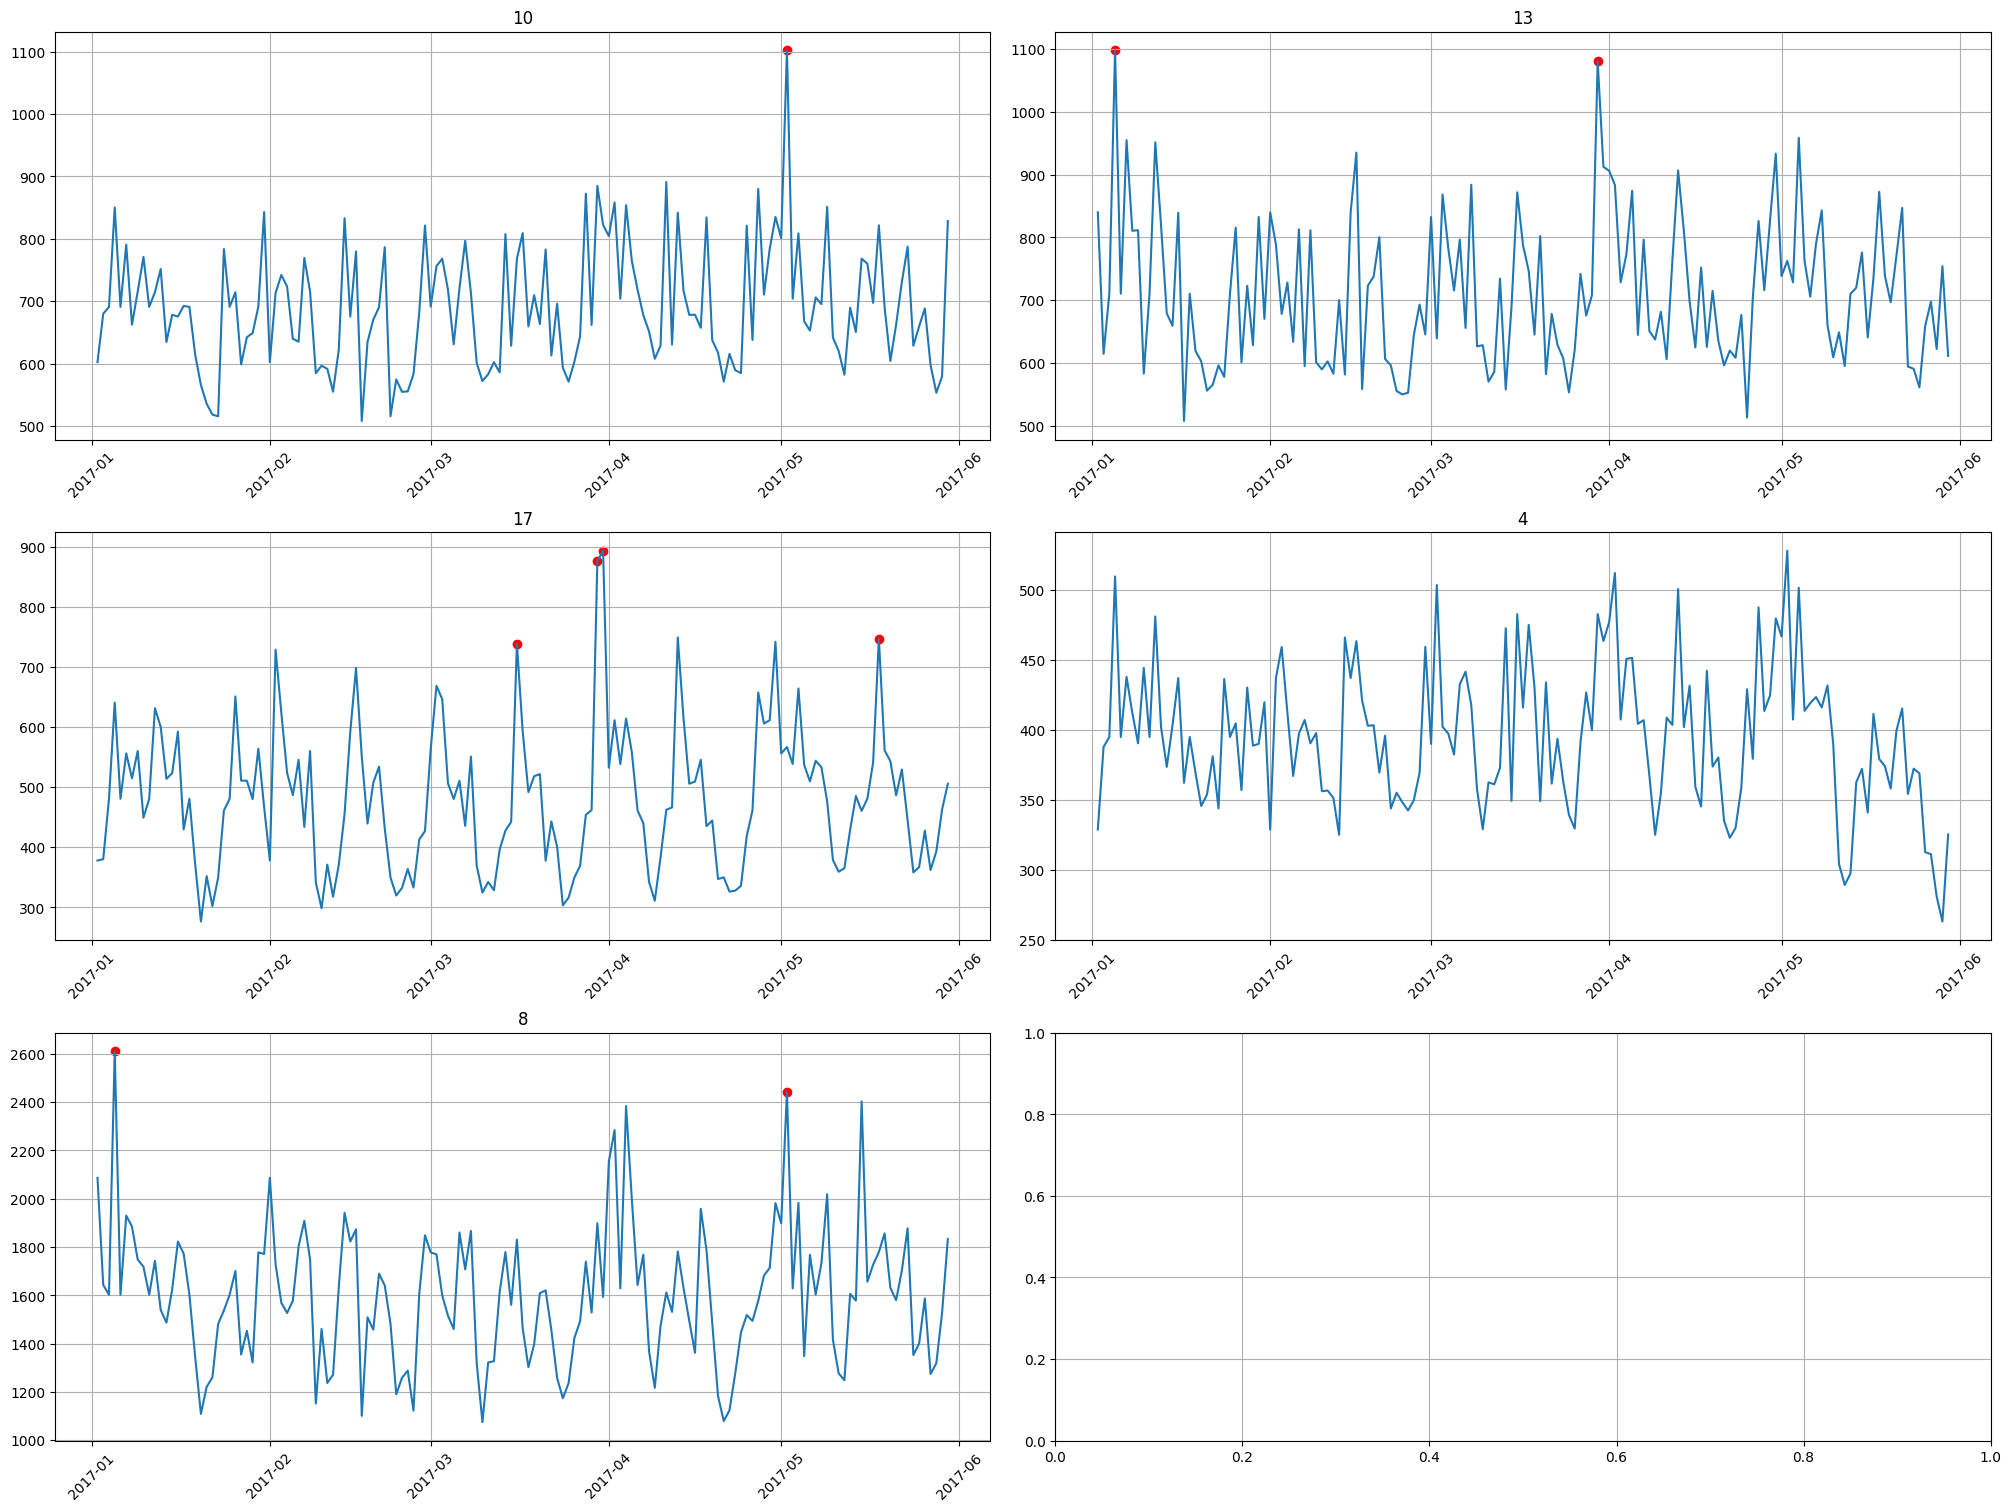

In [30]:
anomaly_dict = get_anomalies_density(ts_train_space, window_size=14, distance_coef=1.5, n_neighbors=3)
plot_anomalies(ts_train_space, anomaly_dict)

**Итог:**

Данный метод нахождения выбросов основан на разложении Holt Winters и IsolationForest. Подробнее можно посмотреть в этой презентации [Тинькофф](https://acdn.tinkoff.ru/static/meetups/talks/67b29965-1010-4ca3-9259-b75c82d366c8.pdf). Параметры были подобраны эвристически. 

Видно, что выбросов не так и много, однако от них стоит избавиться, что мы сделаем впоследствии

### Baseline

**<p style="text-align:center;">Используемые метрики</p>**
1. $$SMAE = \frac{1}{\bar{y}^n_T}\sum\limits^{H}_{i=1}|y^n_{T+i}-\hat{y}^n_{T+i|T}|$$
2. $$SMAPE = \frac{100\%}{n}\sum\limits^{H}_{i=1}\frac{|y_{T+i}-\hat{y}_{T+i|T}|}{(|y_{T+i}|+|\hat{y}_{T+i|T}|)/2}$$

In [31]:
def sMAE(y_true,y_pred,y_train):
    return mean_absolute_error(y_true,y_pred)/y_train.mean()

> NaiveModel

In [32]:
HORIZON = 31
model = NaiveModel(lag=14)
model.fit(ts_train_nospace)
forecast_ts = model.forecast(deepcopy(ts_train_nospace), prediction_size=HORIZON)

In [33]:
smae_pipeline = {'Segment':[],'sMAE':[]}
for i in segments_with_nospace:
    smae_pipeline['Segment'].append(i)
    smae_pipeline['sMAE'].append(sMAE(ts_train_nospace.df[(str(i),'target')][-30:],forecast_ts.df[(str(i),'target')][-30:],ts_train_nospace.df[('0','target')]))
smae_pipeline = pd.DataFrame(smae_pipeline)
smae_pipeline

Segment      sMAE
0         0  0.223683
1         1  0.140081
2         2  0.122864
3         3  0.164040
4         5  0.171555
5         6  0.254266
6         7  0.133836
7         9  0.216543
8        11  0.192419
9        12  0.286003
10       14  0.193355
11       15  0.220534
12       16  0.122636
13       18  0.208967

**Наивная модель:** Возьмем ее как бейзлайн для проверки качества наших будущих моделей

### Transforms

**Используемые преобразования:**
1. Сезонная компонента(Deseasonality Transform)
2. Трендовая компонента(Linear Trend Transform)
3. Обработка выбросов(Density Outliers Transform)
4. Данные на основе дат(Date Flag Transform)
5. Добавление лагов(Lag Transform)
6. Статистические показатели(Running mean, std, fourier transform etc)

In [34]:
lags_dict_nospace = {
    '0': [12, 21,33],
    '1': [13, 21,33],
    '11': [14, 21,33],
    '12': [13, 21,33],
    '14': [12, 21,33],
    '15': [13, 21,33],
    '16': [15, 21,33],
    '18': [13, 21,33],
    '19': [14, 21,33],
    '2': [12, 21,33],
    '3': [13, 21,33],
    '5': [15, 21,33],
    '6': [14, 21,33],
    '7': [15, 21,33],
    '9': [13, 21,33]
}
lags_dict_space = {
    '4': [10, 12,33],
    '8': [10, 13,33],
    '10': [12, 14,33],
    '13': [11, 13,33],
    '17': [12, 15,33]
}

In [35]:
seasonal_dict_nospace = {
    '0': 14,
    '1': 7,
    '12':14,
    '14':14,
    '18':21,
    '19':14,
    '2':11,
    '3':10,
    '5':8,
    '6':8,
    '7':7,
    '9':18
}
seasonal_dict_space = {
    '10':12,
    '13':12,
    '17':12,
    '4':12,
    '8':12
}

In [37]:
transforms = [
    CustomLagTransform(in_column='target',
    lags=lags_dict_nospace,
    out_column='lag'),
    CustomSeasonal(in_column='target',
    period=seasonal_dict_nospace,
    lag=5,
    out_column='seasonal'
    ),
    LinearTrendTransform(in_column='target',poly_degree=2),
    DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    week_number_in_month=True,
    is_weekend=False,
    out_column="date_flag",
    ),
    StdTransform(in_column='target',window=14,seasonality=7,out_column='runstd'),
    QuantileTransform(in_column='target',quantile=0.25,window=14,seasonality=21,out_column='runquantile'),
    TimeSeriesImputerTransform(in_column='target',strategy="mean", window=7)]

**Итог:** Данные трансформации данных должны способствовать лучшей описительной способности модели. Лаги были подобраны на основе стабильности модели в предсказании обучающей/тестовой выборки, а также с помощью ACF в EDA. Была взята сезонная компонента с лагом 5, а также для большей стабильности избавимся от трендовой компоненты(LinearTrendTransform). Помимо этого возьмем информацию о датах и статистических показателях временного ряда.

### Model Selection

Будем рассматривать два типа прогнозирования: Direct, Recursive для сегментов без больших пробелов(No Space). Для сегментов с большими пробелами(Space) будем использовать ARIMA модели, так как прогнозирование в этих сегментах основано на коротких временных рядах. Также во время исследования прямые и рекурсивные стратегии показали себя хуже по сравнению с ARIMA(с точки зрения стабильности и прогнозных способностей).

**<p style="text-align:center;">No Space </p>**


> **Direct Strategy**

In [38]:
tscv = TimeSeriesSplit(n_splits=3,test_size=30)
transforms = [
    CustomLagTransform(in_column='target',
    lags=lags_dict_nospace,
    out_column='lag'),
    CustomSeasonal(in_column='target',
    period=seasonal_dict_nospace,
    lag=14,
    out_column='seasonal'
    ),
    DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    is_weekend=False,
    out_column="date_flag",
    ),
    StdTransform(in_column='target',window=14,seasonality=7,out_column='runstd'),
    QuantileTransform(in_column='target',quantile=0.25,window=14,seasonality=21,out_column='runquantile'),
    TimeSeriesImputerTransform(in_column='target',strategy="mean", window=7)]
pipelines = {
    '0': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '1': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '2': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '3': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '5': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '6': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '7': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '9': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '11': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '12': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '14': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '15': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '16': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '18': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON)
    }

In [39]:
smae_pipeline1 = {'Segment':[],'sMAE_train':[],'sMAE_test':[],'Fold':[]}
for i in (segments_with_nospace):
    for split, (train_index,test_index) in enumerate(tscv.split(ts_train_nospace[:,str(i),:])):
        freq = ts_train_nospace[:,str(i),:].iloc[train_index]
        pipelines[str(i)].fit(TSDataset(ts_train_nospace[:,str(i),:].iloc[train_index],freq='D'))
        forecast_pipeline_df = pipelines[str(i)].predict(deepcopy(TSDataset(ts_train_nospace[:,str(i),:],freq='D')),start_timestamp=freq.index[0],end_timestamp=freq.index[-1])
        forecast = pipelines[str(i)].forecast()
        smae_pipeline1['Segment'].append(i)
        smae_pipeline1['sMAE_train'].append(sMAE(ts_train_nospace.df[(str(i),'target')].iloc[train_index],forecast_pipeline_df.df[(str(i),'target')],ts_train_nospace.df[(str(i),'target')].iloc[train_index]))
        smae_pipeline1['sMAE_test'].append(sMAE(ts_train_nospace.df[(str(i),'target')].iloc[test_index],forecast[:,str(i),:][(str(i),'target')],ts_train_nospace.df[(str(i),'target')].iloc[train_index]))
        smae_pipeline1['Fold'].append(split)

> **Recursive Strategy**

In [39]:
pipelines = {
    '0': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '1': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '2': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '3': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '5': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '6': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '7': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '9': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '11': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '12': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '14': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '15': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '16': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
    '18': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON)
    }

In [41]:
smae_pipeline2 = {'Segment':[],'sMAE_train':[],'sMAE_test':[],'Fold':[]}
for i in (segments_with_nospace):
    for split, (train_index,test_index) in enumerate(tscv.split(ts_train_nospace[:,str(i),:])):
        freq = ts_train_nospace[:,str(i),:].iloc[train_index]
        pipelines[str(i)].fit(TSDataset(ts_train_nospace[:,str(i),:].iloc[train_index],freq='D'))
        forecast_pipeline_df = pipelines[str(i)].predict(deepcopy(TSDataset(ts_train_nospace[:,str(i),:],freq='D')),start_timestamp=freq.index[0],end_timestamp=freq.index[-1])
        forecast = pipelines[str(i)].forecast()
        smae_pipeline2['Segment'].append(i)
        smae_pipeline2['sMAE_train'].append(sMAE(ts_train_nospace.df[(str(i),'target')].iloc[train_index],forecast_pipeline_df.df[(str(i),'target')],ts_train_nospace.df[(str(i),'target')].iloc[train_index]))
        smae_pipeline2['sMAE_test'].append(sMAE(ts_train_nospace.df[(str(i),'target')].iloc[test_index],forecast[:,str(i),:][(str(i),'target')],ts_train_nospace.df[(str(i),'target')].iloc[train_index]))
        smae_pipeline2['Fold'].append(split)

In [42]:
smae_pipeline1 = pd.DataFrame(smae_pipeline1)
smae_pipeline2 = pd.DataFrame(smae_pipeline2)


In [43]:
pd.concat([smae_pipeline1.groupby('Segment')[['sMAE_train','sMAE_test']].mean(),smae_pipeline2.groupby('Segment')[['sMAE_train','sMAE_test']].mean()],axis=1,keys=['Direct','Recursive'])

Direct            Recursive          
        sMAE_train sMAE_test sMAE_train sMAE_test
Segment                                          
0         0.062687  0.114828   0.062687  0.112300
1         0.069856  0.129006   0.069856  0.117733
2         0.051597  0.085536   0.051597  0.084020
3         0.086524  0.142131   0.086524  0.135124
5         0.073165  0.144214   0.073165  0.158486
6         0.073457  0.166188   0.073457  0.144565
7         0.054852  0.091416   0.054852  0.097133
9         0.065252  0.128178   0.065252  0.122745
11        0.063226  0.131088   0.063226  0.123954
12        0.083945  0.167364   0.083945  0.156923
14        0.071008  0.144083   0.071008  0.138092
15        0.063373  0.116830   0.063373  0.109520
16        0.067523  0.115268   0.067523  0.119698
18        0.071804  0.138071   0.071804  0.124465

**Итог:**
| Сегмент | Лучшая модель | sMAE<sub>test</sub> |
|---------|---------------|---------------------|
| 0       | Recursive     | 0.112300           |
| 1       | Recursive     | 0.117733           |
| 2       | Recursive     | 0.084020           |
| 3       | Recursive     | 0.135124           |
| 5       | Direct        | 0.144214           |
| 6       | Recursive     | 0.144565           |
| 7       | Direct        | 0.091416           |
| 9       | Recursive     | 0.122745           |
| 11      | Recursive     | 0.123954           |
| 12      | Recursive     | 0.156923           |
| 14      | Recursive     | 0.138092           |
| 15      | Recursive     | 0.109520           |
| 16      | Direct        | 0.115268           |
| 18      | Recursive     | 0.124465           |

**<p style="text-align:center;">Space</p>**


Параметры p,d,q для ARIMA моделей мы будем подбирать с помощью перебора по сетке (p,d,q) и минимизацией AIC

In [40]:
transforms = [
    CustomLagTransform(in_column='target',
    lags=lags_dict_space,
    out_column='lag'),
    CustomSeasonal(in_column='target',
    period=seasonal_dict_space,
    lag=5,
    out_column='seasonal'
    ),
    LinearTrendTransform(in_column='target',poly_degree=2),
    DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    is_weekend=False,
    out_column="date_flag",
    ),
    StdTransform(in_column='target',window=14,seasonality=7,out_column='runstd'),
    QuantileTransform(in_column='target',quantile=0.25,window=14,seasonality=21,out_column='runquantile'),
    TimeSeriesImputerTransform(in_column='target',strategy="mean", window=7)]

In [ ]:
filterwarnings('ignore')
ts_train_space1, ts_train_space2 = ts_train_space.train_test_split(train_end='2017-04-30')
min_aic = float('inf')
best_params_arima = dict(zip(segments_with_space,[{'p':0,'d':0,'q':0}]*5))
for i in segments_with_space:
    min_aic = float('inf')
    for p in tqdm(range(0,10)):
        for d in range(3):
            for q in range(0,10):
                try:
                    ar = ARIMA(ts_train_space1.df[(str(i),'target')],order=(p,d,q)).fit()
                    if ar.aic < min_aic:
                        min_aic = ar.aic
                        best_params_arima[i]['p'] = p
                        best_params_arima[i]['d'] = d
                        best_params_arima[i]['q'] = q
                except:
                    pass

In [231]:
smae_pipeline = {'Segment':[],'sMAE_train':[],'sMAE_test':[],'Fold':[]}
for j,i in (enumerate(segments_with_space)):
    for split, (train_index,test_index) in enumerate(tscv.split(ts_train_space[:,str(i),:])):
        order = (best_params_arima[i]['p'],best_params_arima[i]['d'],best_params_arima[i]['q'])
        ar = ARIMA(ts_train_space.df[(str(i),'target')].iloc[train_index],order=order).fit()
        forecast_pipeline_df = ar.get_prediction().predicted_mean
        forecast = ar.forecast(int(test_index[-1]-train_index[-1]))
        smae_pipeline['Segment'].append(i)
        smae_pipeline['sMAE_train'].append(sMAE(ts_train_space.df[(str(i),'target')].iloc[train_index],forecast_pipeline_df,ts_train_space.df[(str(i),'target')].iloc[train_index]))
        smae_pipeline['sMAE_test'].append(sMAE(ts_train_space.df[(str(i),'target')].iloc[test_index],forecast,ts_train_space.df[(str(i),'target')].iloc[train_index]))
        smae_pipeline['Fold'].append(split)
smae_pipeline = pd.DataFrame(smae_pipeline)

In [232]:
smae_pipeline.groupby('Segment').mean()

sMAE_train  sMAE_test  Fold
Segment                             
4          0.087540   0.113780   1.0
8          0.121930   0.129060   1.0
10         0.106482   0.119026   1.0
13         0.137518   0.119884   1.0
17         0.159522   0.181474   1.0

### Fine Tuning

In [100]:
transforms = [
    CustomLagTransform(in_column='target',
    lags=lags_dict_nospace,
    out_column='lag'),
    CustomSeasonal(in_column='target',
    period=seasonal_dict_nospace,
    lag=14,
    out_column='seasonal'
    ),
    DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    is_weekend=False,
    out_column="date_flag",
    ),
    StdTransform(in_column='target',window=14,seasonality=7,out_column='runstd'),
    QuantileTransform(in_column='target',quantile=0.25,window=14,seasonality=21,out_column='runquantile'),
    TimeSeriesImputerTransform(in_column='target',strategy="mean", window=7)]

In [93]:
optuna_best_params_nospace = {
'0': 0,
'1': 0,
'2': 0,
'3': 0,
'5': 0,
'6': 0,
'7': 0,
'9': 0,
'11': 0,
'12': 0,
'14': 0,
'15': 0,
'16': 0,
'18': 0}
HORIZON = 31
best_pipelines = {
'0': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'1': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'2': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'3': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'5': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'6': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'7': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'9': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'11': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'12': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'14': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'15': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'16': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'18': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON)}
for i in segments_with_nospace:
    tuning = Tune(pipeline=best_pipelines[str(i)], horizon=30,target_metric = SMAPE())
    tuning.params_to_tune.update({'model.n_estimators': IntDistribution(low=300, high=800, step=1)})
    tuned = tuning.fit(TSDataset(ts_train_nospace[:,str(i),:],freq='D'),n_trials=10)
    optuna_best_params_nospace[str(i)] = tuned

**Данные были сохранены локально из-за высокой нагруженности**

In [102]:
best_pipelines = {
'0': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'1': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'2': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'3': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'5': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'6': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'7': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'9': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'11': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'12': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'14': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'15': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'16': Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON),
'18': AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON)}

In [103]:
optuna_best_params_nospace = {'0': {'model.depth': 4,
  'model.l2_leaf_reg': 8.63170900120619,
  'model.learning_rate': 0.044634722733575265,
  'model.n_estimators': 622,
  'model.random_strength': 0.0001256458567522271,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': True,
  'transforms.2.day_number_in_year': True,
  'transforms.2.is_weekend': True,
  'transforms.2.month_number_in_year': False,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': False,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': False,
  'transforms.3.window': 8,
  'transforms.4.quantile': 0.5812728726358587,
  'transforms.4.window': 18,
  'transforms.5.strategy': 'constant',
  'transforms.5.window': 20},
 '1': {'model.depth': 4,
  'model.l2_leaf_reg': 10.955431649177255,
  'model.learning_rate': 0.17138190411780674,
  'model.n_estimators': 305,
  'model.random_strength': 1.240684429442273,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': True,
  'transforms.2.day_number_in_year': True,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': False,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 16,
  'transforms.4.quantile': 0.08110138998799676,
  'transforms.4.window': 7,
  'transforms.5.strategy': 'constant',
  'transforms.5.window': 15},
 '2': {'model.depth': 9,
  'model.l2_leaf_reg': 2.2086366669175264,
  'model.learning_rate': 0.1370114945391552,
  'model.n_estimators': 607,
  'model.random_strength': 0.025977923388445026,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': True,
  'transforms.2.day_number_in_year': True,
  'transforms.2.is_weekend': True,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': True,
  'transforms.2.week_number_in_month': False,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 19,
  'transforms.4.quantile': 0.03183892953130785,
  'transforms.4.window': 15,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 19},
 '3': {'model.depth': 9,
  'model.l2_leaf_reg': 2.2086366669175264,
  'model.learning_rate': 0.1370114945391552,
  'model.n_estimators': 607,
  'model.random_strength': 0.025977923388445026,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': True,
  'transforms.2.day_number_in_year': True,
  'transforms.2.is_weekend': True,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': True,
  'transforms.2.week_number_in_month': False,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 19,
  'transforms.4.quantile': 0.03183892953130785,
  'transforms.4.window': 15,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 19},
 '5': {'model.depth': 7,
  'model.l2_leaf_reg': 1.0708774834547776,
  'model.learning_rate': 0.009578327267738135,
  'model.n_estimators': 460,
  'model.random_strength': 0.24028805225920194,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': False,
  'transforms.2.day_number_in_year': False,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': True,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 11,
  'transforms.4.quantile': 0.9903389473967044,
  'transforms.4.window': 18,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 16},
 '6': {'model.depth': 7,
  'model.l2_leaf_reg': 1.0708774834547776,
  'model.learning_rate': 0.009578327267738135,
  'model.n_estimators': 460,
  'model.random_strength': 0.24028805225920194,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': False,
  'transforms.2.day_number_in_year': False,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': True,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 11,
  'transforms.4.quantile': 0.9903389473967044,
  'transforms.4.window': 18,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 16},
 '7': {'model.depth': 7,
  'model.l2_leaf_reg': 1.0708774834547776,
  'model.learning_rate': 0.009578327267738135,
  'model.n_estimators': 460,
  'model.random_strength': 0.24028805225920194,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': False,
  'transforms.2.day_number_in_year': False,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': True,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 11,
  'transforms.4.quantile': 0.9903389473967044,
  'transforms.4.window': 18,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 16},
 '9': {'model.depth': 9,
  'model.l2_leaf_reg': 2.2086366669175264,
  'model.learning_rate': 0.1370114945391552,
  'model.n_estimators': 607,
  'model.random_strength': 0.025977923388445026,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': True,
  'transforms.2.day_number_in_year': True,
  'transforms.2.is_weekend': True,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': True,
  'transforms.2.week_number_in_month': False,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 19,
  'transforms.4.quantile': 0.03183892953130785,
  'transforms.4.window': 15,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 19},
 '11': {'model.depth': 7,
  'model.l2_leaf_reg': 1.0708774834547776,
  'model.learning_rate': 0.009578327267738135,
  'model.n_estimators': 460,
  'model.random_strength': 0.24028805225920194,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': False,
  'transforms.2.day_number_in_year': False,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': True,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 11,
  'transforms.4.quantile': 0.9903389473967044,
  'transforms.4.window': 18,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 16},
 '12': {'model.depth': 4,
  'model.l2_leaf_reg': 10.955431649177255,
  'model.learning_rate': 0.17138190411780674,
  'model.n_estimators': 305,
  'model.random_strength': 1.240684429442273,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': True,
  'transforms.2.day_number_in_year': True,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': False,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 16,
  'transforms.4.quantile': 0.08110138998799676,
  'transforms.4.window': 7,
  'transforms.5.strategy': 'constant',
  'transforms.5.window': 15},
 '14': {'model.depth': 4,
  'model.l2_leaf_reg': 10.955431649177255,
  'model.learning_rate': 0.17138190411780674,
  'model.n_estimators': 305,
  'model.random_strength': 1.240684429442273,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': True,
  'transforms.2.day_number_in_year': True,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': False,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 16,
  'transforms.4.quantile': 0.08110138998799676,
  'transforms.4.window': 7,
  'transforms.5.strategy': 'constant',
  'transforms.5.window': 15},
 '15': {'model.depth': 7,
  'model.l2_leaf_reg': 0.9897089913495284,
  'model.learning_rate': 0.003696809834089472,
  'model.n_estimators': 362,
  'model.random_strength': 1.303644539431268e-05,
  'transforms.2.day_number_in_month': False,
  'transforms.2.day_number_in_week': False,
  'transforms.2.day_number_in_year': True,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': False,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': True,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 3,
  'transforms.4.quantile': 0.7142412995491114,
  'transforms.4.window': 19,
  'transforms.5.strategy': 'constant',
  'transforms.5.window': 13},
 '16': {'model.depth': 7,
  'model.l2_leaf_reg': 1.0708774834547776,
  'model.learning_rate': 0.009578327267738135,
  'model.n_estimators': 460,
  'model.random_strength': 0.24028805225920194,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': False,
  'transforms.2.day_number_in_year': False,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': True,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 11,
  'transforms.4.quantile': 0.9903389473967044,
  'transforms.4.window': 18,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 16},
 '18': {'model.depth': 7,
  'model.l2_leaf_reg': 1.0708774834547776,
  'model.learning_rate': 0.009578327267738135,
  'model.n_estimators': 460,
  'model.random_strength': 0.24028805225920194,
  'transforms.2.day_number_in_month': True,
  'transforms.2.day_number_in_week': False,
  'transforms.2.day_number_in_year': False,
  'transforms.2.is_weekend': False,
  'transforms.2.month_number_in_year': True,
  'transforms.2.season_number': False,
  'transforms.2.week_number_in_month': True,
  'transforms.2.week_number_in_year': True,
  'transforms.2.year_number': True,
  'transforms.3.window': 11,
  'transforms.4.quantile': 0.9903389473967044,
  'transforms.4.window': 18,
  'transforms.5.strategy': 'mean',
  'transforms.5.window': 16}}

In [42]:
smae_pipeline1 = {'Segment':[],'sMAE_train':[],'sMAE_test':[],'Fold':[]}
tscv = TimeSeriesSplit(n_splits=3,test_size=30)
for i in (segments_with_nospace):
    for split, (train_index,test_index) in enumerate(tscv.split(ts_train_nospace[:,str(i),:])):
        freq = ts_train_nospace[:,str(i),:].iloc[train_index]
        best_pipelines[str(i)].set_params(**optuna_best_params_nospace[str(i)])
        best_pipelines[str(i)].fit(TSDataset(ts_train_nospace[:,str(i),:].iloc[train_index],freq='D'))
        forecast_pipeline_df = best_pipelines[str(i)].predict(deepcopy(TSDataset(ts_train_nospace[:,str(i),:],freq='D')),start_timestamp=freq.index[0],end_timestamp=freq.index[-1])
        forecast = best_pipelines[str(i)].forecast()
        smae_pipeline1['Segment'].append(i)
        smae_pipeline1['sMAE_train'].append(sMAE(ts_train_nospace.df[(str(i),'target')].iloc[train_index],forecast_pipeline_df.df[(str(i),'target')],ts_train_nospace.df[(str(i),'target')].iloc[train_index]))
        smae_pipeline1['sMAE_test'].append(sMAE(ts_train_nospace.df[(str(i),'target')].iloc[test_index],forecast[:,str(i),:][(str(i),'target')],ts_train_nospace.df[(str(i),'target')].iloc[train_index]))
        smae_pipeline1['Fold'].append(split)

In [41]:
pd.DataFrame(smae_pipeline1).groupby('Segment')[['sMAE_train','sMAE_test']].mean()

sMAE_train  sMAE_test
Segment                       
0          0.062687   0.112300
1          0.069856   0.117733
2          0.051597   0.084020
3          0.086524   0.135124
5          0.073165   0.144214
6          0.073457   0.144565
7          0.054852   0.091416
9          0.065252   0.122745
11         0.063226   0.123954
12         0.083945   0.156923
14         0.071008   0.138092
15         0.063373   0.109520
16         0.067523   0.115268
18         0.071804   0.124465

### Forward

In [251]:
def forward():
    preds = {'id':[],'forecast':[],'dt':[]}
    for i in segments_with_nospace:
        best_pipelines[str(i)].set_params(**optuna_best_params_nospace[str(i)])
        best_pipelines[str(i)].fit(TSDataset(ts_train_nospace[:,str(i),:],freq='D'))
        forecast = best_pipelines[str(i)].forecast()
        preds['id'].extend([int(i)]*30)
        preds['forecast'].extend(forecast.df[(str(i),'target')].values.tolist()[1:])
        preds['dt'].extend(forecast.df[(str(i),'target')].index.date.astype(str).tolist()[1:])
        print(i)
    for i in segments_with_space:
        order = (best_params_arima[i]['p'],best_params_arima[i]['d'],best_params_arima[i]['q'])
        ar = ARIMA(ts_train_space.df[(str(i),'target')],order=order).fit()
        forecast = ar.forecast(31)
        preds['id'].extend([int(i)]*30)
        preds['forecast'].extend(forecast.values.tolist()[1:])
        preds['dt'].extend(forecast.index.date.astype(str).tolist()[1:])
    return preds


In [252]:
y_preds = forward()

0
1
2
3
5
6
7
9
11
12
14
15
16
18


In [254]:
ans = pd.DataFrame(y_preds).sort_values(by=['id','dt'])

In [261]:
ans.to_csv('test_answer.csv')

In [262]:
ans

id    forecast          dt
0     0  944.764519  2017-06-01
1     0  872.596043  2017-06-02
2     0  861.922061  2017-06-03
3     0  853.964706  2017-06-04
4     0  765.489672  2017-06-05
..   ..         ...         ...
415  18  550.559558  2017-06-26
416  18  496.470109  2017-06-27
417  18  636.542626  2017-06-28
418  18  838.494357  2017-06-29
419  18  847.026946  2017-06-30

[570 rows x 3 columns]

## <p style="text-align:center;"> Выводы </p>
1. Выявлены 2 разные подвыборки: 5 сегментов имели большой пропуск в данных(~полгода). Поэтому было принято решение о разделении выборок и впоследствии раздельного анализа.

2. Проведен анализ временных рядов по каждому сегменту(магазину): выявлена высокая скоррелированность, стационарность, а также проведен анализ ACF. Помимо этого был проведен анализ сезонности и выявления трендов в каждом сегменте. Модели, предполагающие корреляцию между рядами не были использованы(например, VAR модель), однако в большинстве случаев они имеют худшее качество по сравнению с бустингом или улучшенными версиями ARIMA-моделей. Выявление стационарности с помощью ADF-теста помогло в использовании ARIMA модели. Анализ ACF показал, что существуют взаимосвязи между прошлыми значениями, а также дало уверенность в том, что добавления лаговых значений в модель будет иметь смысл. Были использованы довольно поздние лаги(> 14 дней), так как на них показывалось лучшее качество(SMAPE, sMAE). Выявление тренда не показало ощутимых результатов, однако помогло при сборке признаков. Проверка на сезонность позволила добавить сезонную компоненту в качестве отдельного признака, что улучшило результаты модели.

3. При выборе модели участвовало 3 типа: прямая стратегия с использованием бустинга, рекурсивная стратегия с использованием бустинга, а также ARIMA. На больших временных рядах использовались стратегии(15 сегментов), на коротких - ARIMA. Для каждого сегмента была взята отдельная модель с отдельной стратегией прогнозирования, для ARIMA моделей были перебраны значения p,d,q по AIC. 

4. Подбор гиперпараметров был использован как для признаков, так и для самого бустинга. Подбор осуществлялся с помощью `optuna` с `n_trials` = 10. Были подобраны оптимальные значения для данной выборки.

5. Базовые модели имеют sMAE < 0.15, Наивная модель посегментно имеет sMAE ~ больше 0.2.
